In [27]:
from torch.utils import data
import numpy as np
import  pytorch_fid_wrapper as pfw
from PIL import Image
import os
import glob
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import handshape_datasets as hd
from torchvision import transforms

In [28]:
class Dataloader(data.Dataset):
    
    def __init__(self, dataset, batch_size=128):
        super(Dataloader, self).__init__()
        self.x = dataset[0]
        self.y = dataset[1]
        self.len = dataset[0].shape[0]
        self.batch_size = batch_size
        self.act_idx = 0


    def __getitem__(self, index):
        print(index)
        if (index+self.batch_size <= self.len):
            x = torch.Tensor(self.x[index:index+self.batch_size,:,:,:])  # batch dim is handled by the data loader
            y = torch.Tensor(self.y[index:index+self.batch_size,]) 
        else:
            x2 = torch.Tensor(self.x[index:self.len,:,:,:])  # batch dim is handled by the data loader
            y2 = torch.Tensor(self.y[index:self.len,]) 
            
        return x.permute(0,3, 1, 2), y

    def __len__(self):
        return self.len
    
    def netx(self):
        if (self.act_idx+self.batch_size <= self.len):
            x = torch.Tensor(self.x[self.act_idx:(self.act_idx+self.batch_size),:,:,:]) 
            y = torch.Tensor(self.y[self.act_idx:(self.act_idx+self.batch_size),])
            self.act_idx += self.batch_size
        else:
            x = torch.Tensor(self.x[self.act_idx:self.len-1,:,:,:]) 
            y = torch.Tensor(self.y[self.act_idx:self.len-1,])
            self.act_idx = self.len

        return x.permute(0,3, 1, 2), y
    
    def reset_index(self):
        self.act_idx = 0

In [29]:
def load_dataset():
    
    data = hd.load('rwth')

    good_min = 40
    good_classes = []
    n_unique = len(np.unique(data[1]['y']))
    for i in range(n_unique):
        images = data[0][np.equal(i, data[1]['y'])]
        if len(images) >= good_min:
            good_classes = good_classes + [i]

    x = data[0][np.in1d(data[1]['y'], good_classes)]
    img_shape = x[0].shape
    print(img_shape)
    y = data[1]['y'][np.in1d(data[1]['y'], good_classes)]
    y_dict = dict(zip(np.unique(y), range(len(np.unique(y)))))
    y = np.vectorize(y_dict.get)(y)
    classes = np.unique(y)
    n_classes = len(classes)
    
    #escalo al rango  [1-,1]
    x = (x.astype('float32') -127.5 ) / 127.5

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, train_size=0.8, test_size=0.2, stratify=y)

    #Reduciendo dataset
    reduce = None
    if reduce:
        for i in range(n_classes):
            images = x_train[np.equal(i, y_train)]
            #x_reduce = x_reduce + images[0:(len(images)//2),:,:,:]
            if i==0:
                x_reduce = images[0:(len(images)//reduce),:,:,:]
                y_reduce = np.ones((len(images)//reduce)) * i
            else:
                x_reduce = np.concatenate((x_reduce, images[0:(len(images)//reduce),:,:,:]), axis=0)
                y_temp = np.ones((len(images)//reduce)) * i
                y_reduce = np.concatenate((y_reduce, y_temp), axis=0)

        print('x.shpae: {}, y.shape: {}'.format(x.shape, y.shape))
        print('x_reduce.shpae: {}, y_reduce.shape: {}'.format(x_reduce.shape, y_reduce.shape))

        #Desordeno el nuevo dataset
        shuffler = np.random.permutation(x_reduce.shape[0])
        x_reduce = x_reduce[shuffler]
        y_reduce = y_reduce[shuffler]
        print("dataset final shape: {}, y final:{}".format(x_reduce.shape,y_reduce.shape))


    train_size = x_train.shape[0]
    test_size = x_test.shape[0]

    return n_classes, x_train, y_train, x_test, y_test 

In [30]:
def load_lsa16_rotated():
    images =[]
    labels = []
    i=0
    path = "/home/willys/tesis/Data-augmentation-using-GANs/datasets/rgb_black_background/"
    for filename in glob.glob(path+'*.png'):
        #append iamge
        image = Image.open(os.path.join(path, filename))
        image_to_numpy=np.asarray(image)
        images.append(image_to_numpy)
        #create label and append
        image_name = filename.split('/')[-1]
        label = (int(image_name.split('_')[0]))
        labels.append(label-1)

    images = np.asarray(images)
    labels = np.asarray(labels)
    n_classes = len(np.unique(labels))
    
    #Desordeno el nuevo dataset
    shuffler = np.random.permutation(images.shape[0])
    images = images[shuffler]
    labels = labels[shuffler]
    
    #escalo al rango  [1-,1]
    images = (images.astype('float32') -127.5 ) / 127.5
    #split
    x_train, x_test, y_train, y_test = train_test_split(
        images, labels, train_size=0.8, test_size=0.2, stratify=labels)
    
    return n_classes, x_train, y_train, x_test, y_test 

In [31]:
def load_lsa16_rotated_with_subject(subject_test=1):
    x_train =[]
    y_train = []
    x_test = []
    y_test = []
    i=0
    path = "/home/willys/tesis/Data-augmentation-using-GANs/datasets/rgb_black_background/"
    for filename in glob.glob(path+'*.png'):
        #append iamge
        image = Image.open(os.path.join(path, filename))
        image_to_numpy=np.asarray(image)
        
        # get label and subject
        image_name = filename.split('/')[-1]
        label = (int(image_name.split('_')[0]))
        subject = (int(image_name.split('_')[1]))
        
        if subject==subject_test:
            x_test.append(image_to_numpy)
            y_test.append(label-1)
        else:
            x_train.append(image_to_numpy)
            y_train.append(label-1)        

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    n_classes = len(np.unique(y_train))
    
    #Desordeno los datos de train
    shuffler_train = np.random.permutation(x_train.shape[0])
    x_train = x_train[shuffler_train]
    y_train = y_train[shuffler_train]
    
    #Desordeno los datos de train
    shuffler_test = np.random.permutation(x_test.shape[0])
    x_test = x_test[shuffler_test]
    y_test = y_test[shuffler_test]
    
    #escalo al rango  [1-,1]
    x_train = (x_train.astype('float32') -127.5 ) / 127.5
    x_test = (x_test.astype('float32') -127.5 ) / 127.5
    
    return n_classes, x_train, y_train, x_test, y_test 

In [32]:
def orthogonal_regularization(weight):
    '''
    Function for computing the orthogonal regularization term for a given weight matrix.
    '''
    weight = weight.flatten(1)
    return torch.norm(
        torch.dot(weight, weight) * (torch.ones_like(weight) - torch.eye(weight.shape[0]))
    )

In [33]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 32, 32), nrow=4, show=True, save=False, 
                       path=''):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if save:
        plt.savefig(path)
    if show:
        plt.show()

In [34]:
class ClassConditionalBatchNorm2d(nn.Module):
    '''
    ClassConditionalBatchNorm2d Class
    Values:
    in_channels: the dimension of the class embedding (c) + noise vector (z), a scalar
    out_channels: the dimension of the activation tensor to be normalized, a scalar
    '''

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.class_scale_transform = nn.utils.spectral_norm(nn.Linear(in_channels, out_channels, bias=False))
        self.class_shift_transform = nn.utils.spectral_norm(nn.Linear(in_channels, out_channels, bias=False))

    def forward(self, x, y):
        normalized_image = self.bn(x)
        class_scale = (1 + self.class_scale_transform(y))[:, :, None, None]
        class_shift = self.class_shift_transform(y)[:, :, None, None]
        transformed_image = class_scale * normalized_image + class_shift
        return transformed_image

In [35]:
class AttentionBlock(nn.Module):
    '''
    AttentionBlock Class
    Values:
    channels: number of channels in input
    '''
    def __init__(self, channels):
        super().__init__()

        self.channels = channels

        self.theta = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.phi = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.g = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 2, kernel_size=1, padding=0, bias=False))
        self.o = nn.utils.spectral_norm(nn.Conv2d(channels // 2, channels, kernel_size=1, padding=0, bias=False))

        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        spatial_size = x.shape[2] * x.shape[3]

        # Apply convolutions to get query (theta), key (phi), and value (g) transforms
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), kernel_size=2)
        g = F.max_pool2d(self.g(x), kernel_size=2)

        # Reshape spatial size for self-attention
        theta = theta.view(-1, self.channels // 8, spatial_size)
        phi = phi.view(-1, self.channels // 8, spatial_size // 4)
        g = g.view(-1, self.channels // 2, spatial_size // 4)

        # Compute dot product attention with query (theta) and key (phi) matrices
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), dim=-1)

        # Compute scaled dot product attention with value (g) and attention (beta) matrices
        o = self.o(torch.bmm(g, beta.transpose(1, 2)).view(-1, self.channels // 2, x.shape[2], x.shape[3]))

        # Apply gain and residual
        return self.gamma * o + x

In [36]:
class GResidualBlock(nn.Module):
    '''
    GResidualBlock Class
    Values:
    c_dim: the dimension of conditional vector [c, z], a scalar
    in_channels: the number of channels in the input, a scalar
    out_channels: the number of channels in the output, a scalar
    '''

    def __init__(self, c_dim, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        self.bn1 = ClassConditionalBatchNorm2d(c_dim, in_channels)
        self.bn2 = ClassConditionalBatchNorm2d(c_dim, out_channels)

        self.activation = nn.ReLU()
        self.upsample_fn = nn.Upsample(scale_factor=2)     # upsample occurs in every gblock

        self.mixin = (in_channels != out_channels)
        if self.mixin:
            self.conv_mixin = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0))

    def forward(self, x, y):
        # h := upsample(x, y)
        h = self.bn1(x, y)
        h = self.activation(h)
        h = self.upsample_fn(h)
        h = self.conv1(h)

        # h := conv(h, y)
        h = self.bn2(h, y)
        h = self.activation(h)
        h = self.conv2(h)

        # x := upsample(x)
        x = self.upsample_fn(x)
        if self.mixin:
            x = self.conv_mixin(x)

        return h + x

In [37]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of random noise sampled, a scalar
    shared_dim: the dimension of shared class embeddings, a scalar
    base_channels: the number of base channels, a scalar
    bottom_width: the height/width of image before it gets upsampled, a scalar
    n_classes: the number of image classes, a scalar
    '''

    def __init__(self, base_channels=96, bottom_width=4, z_dim=120, shared_dim=128, n_classes=1000):
        super().__init__()

        n_chunks = 4    # 3 (generator blocks) + 1 (generator input)
        self.z_chunk_size = z_dim // n_chunks
        self.z_dim = z_dim
        self.shared_dim = shared_dim
        self.bottom_width = bottom_width

        # No spectral normalization on embeddings, which authors observe to cripple the generator
        self.shared_emb = nn.Embedding(n_classes, shared_dim)

        self.proj_z = nn.Linear(self.z_chunk_size, 16 * base_channels * bottom_width ** 2)

        # Can't use one big nn.Sequential since we are adding class+noise at each block
        self.g_blocks = nn.ModuleList([

            nn.ModuleList([
                GResidualBlock(shared_dim + self.z_chunk_size, 16 * base_channels, 4 * base_channels),
                AttentionBlock(4 * base_channels),
            ]),
            nn.ModuleList([
                GResidualBlock(shared_dim + self.z_chunk_size, 4 * base_channels, 2 * base_channels),
                AttentionBlock(2 * base_channels),
            ]),
            nn.ModuleList([
                GResidualBlock(shared_dim + self.z_chunk_size, 2 * base_channels, base_channels),
                AttentionBlock(base_channels),
            ]),
        ])
        self.proj_o = nn.Sequential(
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(base_channels, 3, kernel_size=1, padding=0)),
            nn.Tanh(),
        )
        
    def loss (self, disc_fake_pred):
        
        return - disc_fake_pred.mean()

    def forward(self, z, y):
        '''
        z: random noise with size self.z_dim
        y: class embeddings with size self.shared_dim
            = NOTE =
            y should be class embeddings from self.shared_emb, not the raw class labels
        '''
        # Chunk z and concatenate to shared class embeddings
        zs = torch.split(z, self.z_chunk_size, dim=1)
        z = zs[0]
        ys = [torch.cat([y, z], dim=1) for z in zs[1:]]

        # Project noise and reshape to feed through generator blocks
        h = self.proj_z(z)
        h = h.view(h.size(0), -1, self.bottom_width, self.bottom_width)

        # Feed through generator blocks
        for idx, g_block in enumerate(self.g_blocks):
            h = g_block[0](h, ys[idx])
            h = g_block[1](h)

        # Project to 3 RGB channels with tanh to map values to [-1, 1]
        h = self.proj_o(h)

        return h

In [38]:
class DResidualBlock(nn.Module):
    '''
    DResidualBlock Class
    Values:
    in_channels: the number of channels in the input, a scalar
    out_channels: the number of channels in the output, a scalar
    downsample: whether to apply downsampling
    use_preactivation: whether to apply an activation function before the first convolution
    '''

    def __init__(self, in_channels, out_channels, downsample=True, use_preactivation=False):
        super().__init__()

        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        self.activation = nn.ReLU()
        self.use_preactivation = use_preactivation  # apply preactivation in all except first dblock

        self.downsample = downsample    # downsample occurs in all except last dblock
        if downsample:
            self.downsample_fn = nn.AvgPool2d(2)
        self.mixin = (in_channels != out_channels) or downsample
        if self.mixin:
            self.conv_mixin = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0))

    def _residual(self, x):
        if self.use_preactivation:
            if self.mixin:
                x = self.conv_mixin(x)
            if self.downsample:
                x = self.downsample_fn(x)
        else:
            if self.downsample:
                x = self.downsample_fn(x)
            if self.mixin:
                x = self.conv_mixin(x)
        return x

    def forward(self, x):
        # Apply preactivation if applicable
        if self.use_preactivation:
            h = F.relu(x)
        else:
            h = x

        h = self.conv1(h)
        h = self.activation(h)
        if self.downsample:
            h = self.downsample_fn(h)

        return h + self._residual(x)

In [39]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    base_channels: the number of base channels, a scalar
    n_classes: the number of image classes, a scalar
    '''

    def __init__(self, base_channels=96, n_classes=1000):
        super().__init__()

        # For adding class-conditional evidence
        self.shared_emb = nn.utils.spectral_norm(nn.Embedding(n_classes, 4 * base_channels))

        self.d_blocks = nn.Sequential(
            DResidualBlock(3, base_channels, downsample=True, use_preactivation=False),
            AttentionBlock(base_channels),

            DResidualBlock(base_channels, 2 * base_channels, downsample=True, use_preactivation=True),
            AttentionBlock(2 * base_channels),

            DResidualBlock(2 * base_channels, 4 * base_channels, downsample=True, use_preactivation=True),
            AttentionBlock(4 * base_channels),

            nn.ReLU(inplace=True),
        )
        self.proj_o = nn.utils.spectral_norm(nn.Linear(4 * base_channels, 1))
        
    def loss(self, disc_real_pred, disc_fake_pred):
        
        d_loss_fake = torch.nn.ReLU()(1.0 + disc_fake_pred).mean()
        d_loss_real = torch.nn.ReLU()(1.0 - disc_real_pred).mean()
        
        return d_loss_real + d_loss_fake

    def forward(self, x, y=None):
        h = self.d_blocks(x)
        h = torch.sum(h, dim=[2, 3])

        # Class-unconditional output
        uncond_out = self.proj_o(h)
        if y is None:
            return uncond_out

        # Class-conditional output
        cond_out = torch.sum(self.shared_emb(y) * h, dim=1, keepdim=True)
        
        return uncond_out + cond_out

In [26]:
device = 'cuda'
n_classes = 16
#charge data
#n_classes, x_train, y_train, x_test, y_test = load_dataset()
#n_classes, x_train, y_train, x_test, y_test = load_lsa16_rotated()

#Guardo el split de los datos originales
data_dir = 'generators_weights/lsa_16_rotated/'
#if not os.path.exists(data_dir):
   # os.makedirs(data_dir)
#np.save(data_dir+'x_train',x_train)
#np.save(data_dir+'y_train',y_train)
#np.save(data_dir+'x_test',x_test)
#np.save(data_dir+'y_test',y_test)
x_train = np.load(data_dir+'x_train.npy')
y_train = np.load(data_dir+'y_train.npy')
x_train = (x_train.astype('float32') -127.5 ) / 127.5

dataloader = Dataloader((x_train,y_train), 128)

transforms_scale_64 = transforms.Resize(64)
transforms_scale_32 = transforms.Resize((32,32))

# Initialize models
base_channels = 96
z_dim = 120
n_classes = n_classes   
shared_dim = 128
generator = Generator(base_channels=base_channels, bottom_width=4, z_dim=z_dim, shared_dim=shared_dim, n_classes=n_classes).to(device)
discriminator = Discriminator(base_channels=base_channels, n_classes=n_classes).to(device)

# Initialize weights orthogonally
for module in generator.modules():
    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.Embedding)):
        nn.init.orthogonal_(module.weight)
for module in discriminator.modules():
    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.Embedding)):
        nn.init.orthogonal_(module.weight)

# Initialize optimizers
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.999), eps=1e-6)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=4e-4, betas=(0.0, 0.999), eps=1e-6)

generator.load_state_dict(torch.load('generators_weights/lsa_16_rotated/gen.state_dict'))

<All keys matched successfully>

In [68]:
def train(dataloader, base_channels, z_dim, shared_dim, n_classes,
          generator, discriminator, gen_opt, disc_opt, epochs, weights_dir, summary_fid):
    cur_step = 0
    min_fids = np.array([2000,2000,2000])
    e = 0
    transforms_scale_32 = transforms.Resize((32,32))

    for epoch in range(epochs):
        print('##############################')
        print('#epoch: {}'.format(epoch))
        print('##############################')

        dataloader.reset_index()
        for i in range((dataloader.len//dataloader.batch_size)):
            real, labels = dataloader.netx()
            real = transforms_scale_32(real) 
            batch_size = len(real)
            real = real.to(device)

            for i in range(2):
                ### Update discriminator ###
                # Zero out the discriminator gradients
                disc_opt.zero_grad()
                # Get noise corresponding to the current batch_size 
                z = torch.randn(batch_size, z_dim, device=device)       # Generate random noise (z)
                y = labels.to(device).long()    # Generate a batch of labels (y), one for each class
                y_emb = generator.shared_emb(y)                         # Retrieve class embeddings (y_emb) from generator
                fake = generator(z, y_emb)

                disc_fake_pred = discriminator(fake.detach(), y)  
                disc_real_pred = discriminator(real, y)  

                #loss
                disc_loss = discriminator.loss(disc_real_pred, disc_fake_pred)
                # Update gradients
                disc_loss.backward(retain_graph=True)
                # Update optimizer
                disc_opt.step()



            ### Update generator ###
            # Zero out the generator gradients
            gen_opt.zero_grad()

            fake = generator(z, y_emb)
            disc_fake_pred = discriminator(fake, y)  
            #loss
            gen_loss =  generator.loss(disc_fake_pred)
            # Update gradients
            gen_loss.backward()
            # Update optimizer
            gen_opt.step()

            torch.cuda.empty_cache()
            cur_step +=1

            if cur_step % 50 == 0:
                print('===========================================================================')
                try:
                    val_fid = pfw.fid(fake, real_images=real, device="cuda:0")
                    message = 'FID in step_{}: {}'.format(cur_step, val_fid)
                    print(message)
                    print(message, file=summary_fid)
                    if (val_fid < min_fids).any():
                        idx = min_fids.argmax()
                        min_fids[idx] = val_fid
                        weights_dir_specific = weights_dir+'weights_{}/'.format(idx)
                        if not os.path.exists(weights_dir_specific):
                            os.makedirs(weights_dir_specific)
                        torch.save(generator.state_dict(), weights_dir_specific+'gen.state_dict')
                        path_image = weights_dir_specific+'images_gen.png'
                        show_tensor_images(fake, show=False, save=True, path=path_image)
                except:
                    pass
                    
                show_tensor_images(real)
                show_tensor_images(fake)
                print('===========================================================================')

##############################
#epoch: 0
##############################
FID in step_50: 241


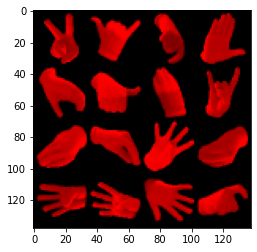

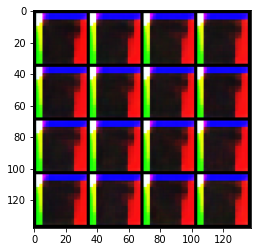

In [67]:
for subject in range(2,3):
    device = 'cuda'
    #charge data
    #n_classes, x_train, y_train, x_test, y_test = load_dataset()
    #n_classes, x_train, y_train, x_test, y_test = load_lsa16_rotated()
    n_classes, x_train, y_train, x_test, y_test = load_lsa16_rotated_with_subject(subject_test=subject)
    
    #Creo los paths 
    weights_dir = 'generators_weights/lsa_16_rotated/subject_{}/'.format(subject)
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    data_dir = 'numpy_data/subject_{}/'.format(subject)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    #Creo un txt para registrar los FID
    summary_fid = open(weights_dir+"summary_fid.txt", "a")
        
    #Guardo el split de los datos originales
    np.save(data_dir+'x_train',x_train)
    np.save(data_dir+'y_train',y_train)
    np.save(data_dir+'x_test',x_test)
    np.save(data_dir+'y_test',y_test)
    
    dataloader = Dataloader((x_train,y_train), 128)

    # Initialize models
    base_channels = 96
    z_dim = 120  
    shared_dim = 128
    generator = Generator(base_channels=base_channels, bottom_width=4, z_dim=z_dim, shared_dim=shared_dim, n_classes=n_classes).to(device)
    discriminator = Discriminator(base_channels=base_channels, n_classes=n_classes).to(device)

    # Initialize weights orthogonally
    for module in generator.modules():
        if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.Embedding)):
            nn.init.orthogonal_(module.weight)
    for module in discriminator.modules():
        if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.Embedding)):
            nn.init.orthogonal_(module.weight)

    # Initialize optimizers
    gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.999), eps=1e-6)
    disc_opt = torch.optim.Adam(discriminator.parameters(), lr=4e-4, betas=(0.0, 0.999), eps=1e-6)
    
    train(dataloader, base_channels, z_dim, shared_dim, n_classes,
          generator, discriminator, gen_opt, disc_opt, 1, weights_dir, summary_fid)
    
    summary_fid.close()

In [45]:
base_channels = 96
z_dim = 120
n_classes = 16   
shared_dim = 128
device='cuda'
generator = Generator(base_channels=base_channels, bottom_width=4, z_dim=z_dim, shared_dim=shared_dim, n_classes=n_classes).to(device)

In [55]:
data_dir = 'generators_weights/lsa_16_rotated/'
total_images = 800
batch_size = 128
x_train = np.load(data_dir+'x_train.npy')
y_train = np.load(data_dir+'y_train.npy')
generator.load_state_dict(torch.load('generators_weights/lsa_16_rotated/gen.state_dict'))
generator.eval()

for j in range(total_images//batch_size):
    for i in range(n_classes):

            #creo imagenes falsas y las mergeo
            z = torch.randn(batch_size, z_dim, device=device)                 # Generate random noise (z)
            y = (torch.ones(batch_size) * i).to(device).long()    # Generate a batch of labels (y), one for each class
            y_emb = generator.shared_emb(y)                                  # Retrieve class embeddings (y_emb) from generator
            fake = transforms_scale_64(generator(z, y_emb)) 

            #acomodo las dimensiones, escala y tipo
            image_unflat = fake.detach().cpu()
            final_images = image_unflat.permute(0,2, 3, 1).numpy()

            x_train = np.concatenate((x_train, final_images), axis=0)
            y_tmp = np.ones(batch_size,)* i
            y_train = np.concatenate((y_train,y_tmp), axis=0)
 

#Desordeno el nuevo dataset
shuffler = np.random.permutation(images.shape[0])
x_train = images[shuffler]
y_train = labels[shuffler]
print(" dataset final shape: {}, y final:{}".format(x_train.shape,y_train.shape))

#Guardamos los datos mergeados
np.save(data_dir+'x_train_aug',x_train) #para volver a la escala original
np.save(data_dir+'y_train_aug',y_train)

#limpiamos memoria
torch.cuda.empty_cache()

 dataset final shape: (12288, 64, 64, 3), y final:(12288,)
